In [1]:
# Install required packages.
!pip install torch

import os
import torch
import numpy as np
from tqdm import tqdm 

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Defaulting to user installation because normal site-packages is not writeable
2.6.0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
from construct_dataset import SolutionDataset
dataset = SolutionDataset(root='../edges', dims=194) # added pca projection to co-occurrences

In [6]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') # = dims
# print(f'Number of classes: {dataset.num_classes}')


Dataset: SolutionDataset(319120):
Number of graphs: 319120
Number of features: 194


In [7]:
def printstats(index):
    data = dataset[index]  

    print()
    print(data)
    print('=============================================================')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('=============================================================')
    print(f'Data.x: {data.x}')
    print(f'Data.y: {data.y}')

    return (data.x, data.y)

In [8]:
def printstats_obj(data):
    print()
    print(data)
    print('=============================================================')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('=============================================================')
    print(f'Data.x: {data.x}')
    print(f'Data.y: {data.y}')

    return (data.x, data.y)

In [9]:
x1, y1 = printstats(0)


Data(edge_index=[2, 717], name=[718], num_nodes=718, x=[718, 194], y=0)
Number of nodes: 718
Number of edges: 717
Average node degree: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data.x: tensor([[ 1.1583e+01,  1.8985e-01,  1.1228e-02,  ..., -1.3974e-01,
         -1.3974e-01, -1.3974e-01],
        [ 6.7340e-01,  1.2362e+01, -1.4642e-01,  ..., -1.4642e-01,
         -1.4642e-01, -1.4642e-01],
        [-1.0237e-01,  2.3053e-02, -1.0237e-01,  ..., -1.0237e-01,
         -1.0237e-01, -1.0237e-01],
        ...,
        [-1.4363e-01, -1.5694e-01, -1.5694e-01,  ..., -1.5481e-01,
         -1.5481e-01, -1.5694e-01],
        [-9.7487e-02, -9.7487e-02, -9.7487e-02,  ..., -9.7487e-02,
         -9.7487e-02, -9.7487e-02],
        [-1.0291e-01, -1.0291e-01, -1.0291e-01,  ..., -1.0291e-01,
         -1.0291e-01, -1.0291e-01]])
Data.y: 0


In [10]:
NODE_FEATURES = dataset.num_features
NUM_CLASSES = dataset[-1].y.item() + 1

print(NODE_FEATURES)
print(NUM_CLASSES)

194
2526


In [ ]:
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

class LazyGraphDataset(Dataset):
    def __init__(self, chunk_dir, transform=None):
        """
        Args:
            chunk_dir (str): Directory where chunk files are stored.
        """
        super().__init__(None, transform, None)
        # List all chunk files in the given directory
        self.chunk_files = sorted([
            os.path.join(chunk_dir, f) for f in os.listdir(chunk_dir)
            if f.endswith('.pt')
        ])
        # Build cumulative sizes to map a global index to a chunk file and local index.
        self.cum_sizes = []
        total = 0
        self.samples_per_chunk = []
        for file in self.chunk_files:
            data_list = torch.load(file, weights_only=False)
            count = len(data_list)
            self.samples_per_chunk.append(count)
            total += count
            self.cum_sizes.append(total)
        self.total_samples = total

        # Simple cache to avoid reloading the same chunk repeatedly.
        self._cache_file = None
        self._cache_data = None

    def len(self):
        return self.total_samples
    
    def get(self, idx):
        # Determine which chunk file holds the sample at global index idx.
        chunk_idx = 0
        for i, cum_size in enumerate(self.cum_sizes):
            if idx < cum_size:
                chunk_idx = i
                break
        local_idx = idx if chunk_idx == 0 else idx - self.cum_sizes[chunk_idx - 1]

        current_file = self.chunk_files[chunk_idx]
        if self._cache_file == current_file:
            data_list = self._cache_data
        else:
            data_list = torch.load(current_file, weights_only=False)
            self._cache_file = current_file
            self._cache_data = data_list

        data = data_list[local_idx]

        # If the graph is empty, add a dummy node and mark the graph as dummy.
        if data.x is None or data.x.size(0) == 0:
            data.x = torch.zeros((1, NODE_FEATURES), dtype=torch.float)
            data.edge_index = torch.empty((2, 0), dtype=torch.long)
            # Use an invalid label (for example, -1) or any placeholder
            data.y = torch.tensor(-1, dtype=torch.long)
            data.is_dummy = torch.tensor(1, dtype=torch.long)
        else:
            data.is_dummy = torch.tensor(0, dtype=torch.long)
        
        # Ensure that every Data object has a "name" attribute.
        # If missing, add it with a default value (e.g., an empty string).
        if not hasattr(data, 'name'):
            data.name = ""
        
        return data

# Create lazy datasets for training and testing
train_dataset = LazyGraphDataset(chunk_dir=f'train/{NODE_FEATURES}d')
test_dataset = LazyGraphDataset(chunk_dir=f'test/{NODE_FEATURES}d')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1074630a0>>
Traceback (most recent call last):
  File "/Users/andy/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [30]:
# Create DataLoaders that load batches on the fly.
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [39]:
for batch in train_loader:
    if batch is None or batch.x.size(0) == 0:
        continue
    print(batch)
    printstats_obj(batch)
    break

DataBatch(edge_index=[2, 717], name=[1], num_nodes=718, x=[718, 194], y=[1], is_dummy=[1], batch=[718], ptr=[2])

DataBatch(edge_index=[2, 717], name=[1], num_nodes=718, x=[718, 194], y=[1], is_dummy=[1], batch=[718], ptr=[2])
Number of nodes: 718
Number of edges: 717
Average node degree: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data.x: tensor([[ 1.1583e+01,  1.8985e-01,  1.1228e-02,  ..., -1.3974e-01,
         -1.3974e-01, -1.3974e-01],
        [ 6.7340e-01,  1.2362e+01, -1.4642e-01,  ..., -1.4642e-01,
         -1.4642e-01, -1.4642e-01],
        [-1.0237e-01,  2.3053e-02, -1.0237e-01,  ..., -1.0237e-01,
         -1.0237e-01, -1.0237e-01],
        ...,
        [-1.4363e-01, -1.5694e-01, -1.5694e-01,  ..., -1.5481e-01,
         -1.5481e-01, -1.5694e-01],
        [-9.7487e-02, -9.7487e-02, -9.7487e-02,  ..., -9.7487e-02,
         -9.7487e-02, -9.7487e-02],
        [-1.0291e-01, -1.0291e-01, -1.0291e-01,  ..., -1.0291e-01,
         -1.0291e-01, -1.0291e-01

In [99]:
def global_stats_pool(data):
    """
    Compute a richer graph-level embedding by concatenating:
      - The mean of node features,
      - The maximum of node features,
      - The standard deviation of node features.
    If the graph is empty, return a zero vector.
    """
    feature_dim = NODE_FEATURES  # Known number of features.
    if data is None or data.x.size(0) == 0:
        return torch.zeros(feature_dim * 3, device=device)
    mean = data.x.mean(dim=0)
    max_val = data.x.max(dim=0)[0]
    std = data.x.std(dim=0, unbiased=False)
    return torch.cat([mean, max_val, std], dim=0)

In [100]:
def concat_pad_embedding(data, max_nodes):
    """
    Default embedding method: Concatenates the node feature vectors (assumed to be in preorder)
    from a graph, then truncates or pads them to a fixed number of nodes, and finally flattens
    the result into a single vector.
    
    Args:
        data (Data): A torch_geometric Data object with data.x of shape [num_nodes, feature_dim].
        max_nodes (int): The fixed number of nodes to use for the embedding.
    
    Returns:
        torch.Tensor: A tensor of shape [1, max_nodes * feature_dim].
    """
    if data.x.size(0) == 0:
        # If there are no nodes, return a zero vector.
        feature_dim = data.x.size(1) if data.x.dim() > 1 else 0
        return torch.zeros(1, max_nodes * feature_dim, device=data.x.device)
    
    num_nodes = data.x.size(0)
    feature_dim = data.x.size(1)
    
    if num_nodes >= max_nodes:
        selected = data.x[:max_nodes]
    else:
        pad_size = max_nodes - num_nodes
        padding = torch.zeros(pad_size, feature_dim, device=data.x.device)
        selected = torch.cat([data.x, padding], dim=0)
    
    # Flatten the [max_nodes, feature_dim] matrix into a vector.
    embedding = selected.view(1, -1)
    return embedding

In [ ]:
from sklearn.decomposition import PCA

class KNNClassifier:
    def __init__(self, embedding_method=None, k=1, pca_dim=128, max_nodes=512):
        """
        Args:
            embedding_method (callable, optional): A function that takes a graph Data object
                and returns a 2D tensor of shape [1, d] as its embedding. If None, a default
                embedding method that concatenates node features (with truncation/padding) is used.
            k (int): Number of nearest neighbors.
            pca_dim (int): Target dimensionality for the graph-level PCA.
            max_nodes (int): Fixed number of nodes per graph (for truncation/padding).
        """
        self.k = k
        self.pca_dim = pca_dim
        self.max_nodes = max_nodes
        
        # If no embedding method is provided, use the default concat_pad_embedding.
        if embedding_method is None:
            self.embedding_method = lambda data: concat_pad_embedding(data, self.max_nodes)
        else:
            self.embedding_method = embedding_method
        
        self.train_embeddings = None  # Graph-level PCA-transformed embeddings.
        self.train_labels = None      # Tensor of shape [N]
        self.pca = None             # Graph-level PCA (fitted on concatenated embeddings).
    
    def update_k(self, new_k):
        """Update the number of nearest neighbors used at inference time."""
        self.k = new_k
    
    def get_embedding(self, data):
        """
        Get the graph-level raw embedding using the provided embedding method.
        
        Args:
            data: A torch_geometric Data object.
        
        Returns:
            torch.Tensor: A tensor of shape [1, d] representing the embedding.
        """
        return self.embedding_method(data)
    
    def fit(self, loader):
        """
        Fit the KNN classifier by computing graph-level raw embeddings for the training set,
        then fitting a PCA model to reduce their dimensionality.
        
        Args:
            loader: A DataLoader that yields graph Data objects (assumed batch size = 1).
        """
        embeddings = []
        labels = []
        for batch in tqdm(loader, desc="Fitting"):
            if batch is None or batch.x.size(0) == 0:
                continue
            emb = self.get_embedding(batch)  # Expected shape: [1, d]
            # If batch contains more than one graph (unlikely with batch_size=1),
            # iterate over them.
            for i in range(emb.size(0)):
                embeddings.append(emb[i].unsqueeze(0))
                labels.append(batch.y[i].item())
        if embeddings:
            raw_embeddings = torch.cat(embeddings, dim=0)  # Shape: [N, d]
            self.train_labels = torch.tensor(labels, dtype=torch.long)
            raw_np = raw_embeddings.cpu().numpy()
            self.pca = PCA(n_components=self.pca_dim)
            transformed = self.pca.fit_transform(raw_np)
            self.train_embeddings = torch.tensor(transformed, dtype=torch.float)
        else:
            self.train_embeddings = torch.empty((0, self.pca_dim))
            self.train_labels = torch.empty((0,), dtype=torch.long)
    
    def predict(self, data, metric="cosine", top_c=1):
        """
        Predict the top c label(s) for one or more graphs.
        
        Args:
            data: A torch_geometric Data object (or batch) for which to predict labels.
            metric (str): Similarity metric to use. Options are "cosine" (default),
                        "manhattan", or "euclidean".
            top_c (int): Number of top predicted labels to return per sample (c <= k).
            
        Returns:
            torch.Tensor: A tensor of shape [B, top_c] containing the top c predicted labels
                        for each graph.
        """
        embeddings_raw = self.get_embedding(data)  # Expected shape: [B, d]
        if self.pca is None:
            return torch.zeros((embeddings_raw.size(0), top_c), dtype=torch.long)
        
        embeddings_np = embeddings_raw.cpu().detach().numpy()
        if embeddings_np.ndim == 1:
            embeddings_np = embeddings_np.reshape(1, -1)
        
        transformed_np = self.pca.transform(embeddings_np)  # Shape: [B, pca_dim]
        embeddings_transformed = torch.tensor(transformed_np, dtype=torch.float)
        
        if self.train_embeddings.size(0) == 0:
            return torch.zeros((embeddings_transformed.size(0), top_c), dtype=torch.long)
        
        # Compute pairwise distances using the specified metric.
        if metric == "euclidean":
            dists = torch.cdist(embeddings_transformed, self.train_embeddings, p=2)
        elif metric == "manhattan":
            dists = torch.cdist(embeddings_transformed, self.train_embeddings, p=1)
        elif metric == "cosine":
            # Normalize to compute cosine similarity.
            q_norm = embeddings_transformed / embeddings_transformed.norm(dim=1, keepdim=True)
            t_norm = self.train_embeddings / self.train_embeddings.norm(dim=1, keepdim=True)
            similarity = torch.mm(q_norm, t_norm.t())
            dists = 1 - similarity
        else:
            raise ValueError(f"Unsupported metric: {metric}")
        
        batch_preds = []
        for i in range(dists.size(0)):
            dist = dists[i]
            # Get indices of the k nearest neighbors.
            knn_indices = torch.topk(dist, self.k, largest=False).indices
            knn_labels = self.train_labels[knn_indices].flatten().long()
            if knn_labels.numel() == 0 or (knn_labels < 0).any():
                batch_preds.append([0] * top_c)
            else:
                counts = torch.bincount(knn_labels)
                # Retrieve top_c labels by vote count.
                num_available = counts.size(0)
                num_to_get = min(top_c, num_available)
                top_counts, top_labels = torch.topk(counts, num_to_get, largest=True)
                pred_labels = top_labels.tolist()
                # If there are fewer than top_c unique labels, pad with zeros.
                if len(pred_labels) < top_c:
                    pred_labels += [0] * (top_c - len(pred_labels))
                batch_preds.append(pred_labels)
        return torch.tensor(batch_preds)


In [120]:
import joblib

# definitions for saving/loading knn

def save_knn(knn_model, file_prefix):
        """
        Save the training embeddings and labels to disk.
        Parameters:
            file_prefix (str): A prefix for the saved file names.
        This method will save:
          - Embeddings to '<file_prefix>_embeddings.pt'
          - Labels to '<file_prefix>_labels.pt'
          - PCA model (if available) to '<file_prefix>_pca.joblib'
        """
        if knn_model.train_embeddings is None or knn_model.train_labels is None:
            print("No training data available to save.")
            return

        torch.save(knn_model.train_embeddings, f"{file_prefix}_embeddings.pt")
        torch.save(knn_model.train_labels, f"{file_prefix}_labels.pt")
        print(f"Saved embeddings to {file_prefix}_embeddings.pt")
        print(f"Saved labels to {file_prefix}_labels.pt")
        
        if knn_model.pca is not None:
            joblib.dump(knn_model.pca, f"{file_prefix}_pca.joblib")
            print(f"Saved PCA model to {file_prefix}_pca.joblib")

def load_knn(file_prefix, embedding_method, pca_dim=100, max_nodes=512):
        """
        Load a KNNClassifier from previously saved training data.
        This method loads:
          - '{file_prefix}_embeddings.pt'
          - '{file_prefix}_labels.pt'
          - '{file_prefix}_pca.joblib' (if available)
        Returns:
            An instance of KNNClassifier with the loaded data.
        """
        instance = KNNClassifier(k=1, embedding_method=embedding_method, pca_dim=pca_dim, max_nodes=max_nodes)
        try:
            instance.train_embeddings = torch.load(f"{file_prefix}_embeddings.pt")
            instance.train_labels = torch.load(f"{file_prefix}_labels.pt")
            instance.pca = joblib.load(f"{file_prefix}_pca.joblib")
            print(f"Loaded embeddings, labels, and PCA model from '{file_prefix}'")
        except Exception as e:
            print("Error loading saved KNN data:", e)
        return instance

In [78]:
# Initialize and fit the KNN classifier!
knn = KNNClassifier(embedding_method=None, pca_dim=NODE_FEATURES, max_nodes=512)
knn.fit(train_loader)

Fitting: 100%|██████████| 287208/287208 [01:35<00:00, 3014.99it/s]


In [79]:
save_knn(knn, "knn/knn_concat_10d")

Saved embeddings to knn/knn_concat_10d_embeddings.pt
Saved labels to knn/knn_concat_10d_labels.pt
Saved PCA model to knn/knn_concat_10d_pca.joblib


In [121]:
knn = load_knn("knn/knn_statpool_194d", embedding_method=global_stats_pool, pca_dim=NODE_FEATURES)

Loaded embeddings, labels, and PCA model from 'knn/knn_statpool_194d'


In [ ]:
import math

# Define how many test samples to skip (e.g., only process every 100th sample)
skip_factor = 1

# Define a range of k values to evaluate.
k_values = [5]
accuracies = []

# Compute the total number of evaluations (if test_loader supports len())
total_evals = math.ceil(len(test_loader) / skip_factor) if hasattr(test_loader, '__len__') else None

for k in k_values:
    # Update the classifier with the new k.
    knn.update_k(k)
    
    correct = 0
    total = 0
    # Set up tqdm with the total number of evaluations.
    with tqdm(total=total_evals, desc=f"Evaluating k={k}") as pbar:
        i = 0
        for batch in test_loader:
            # Skip samples that are not every skip_factor-th sample.
            if i % skip_factor != 0:
                i += 1
                continue

            # Evaluate this single sample (batch size is 1) using top_c=3.
            preds = knn.predict(batch, metric="cosine", top_c=5)  # preds shape: [1, 3]
            total += 1
            true_label = batch.y.item()
            # Check if the true label is among the top 3 predictions.
            if true_label in preds[0].tolist():
                correct += 1
            current_accuracy = 100 * correct / total if total > 0 else 0
            pbar.set_postfix_str(f"Acc: {current_accuracy:.2f}%")
            pbar.update(1)
            i += 1

    accuracy = 100 * correct / total if total > 0 else 0
    print(f"k = {k}: Test Accuracy = {accuracy:.2f}%")
    accuracies.append(accuracy)

Evaluating k=5:   1%|▏         | 461/31912 [00:07<08:37, 60.77it/s, Acc: 67.10%]

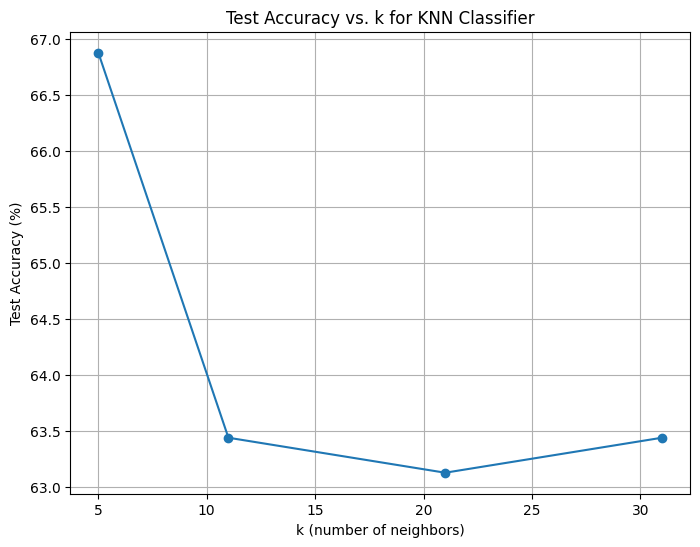

In [130]:
import matplotlib.pyplot as plt

# Plot the results.
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("k (number of neighbors)")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs. k for KNN Classifier")
plt.grid(True)
plt.show()

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Define an AST embedder that processes the node sequence (in preorder)
class ASTEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        """
        Args:
            input_dim (int): Dimension of each node feature.
            hidden_dim (int): Dimension of the GRU hidden state (output embedding size).
            num_layers (int): Number of GRU layers.
        """
        super(ASTEmbedder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
    
    def forward(self, node_features):
        """
        Args:
            node_features (torch.Tensor): Tensor of shape [B, L, input_dim], where
                B is batch size (here 1), and L is the number of nodes.
        Returns:
            torch.Tensor: Final hidden state of shape [B, hidden_dim].
        """
        # We assume that the sequence is already in the desired preorder.
        output, h_n = self.gru(node_features)
        # h_n has shape [num_layers, B, hidden_dim]
        # Return the hidden state from the last layer.
        return h_n[-1, :, :]  # shape [B, hidden_dim]

# 2. Update the KNNClassifier to use the ASTEmbedder.
class KNNClassifier:
    def __init__(self, k=5, embedder=None, pca_dim=None):
        """
        Args:
            k (int): Number of nearest neighbors.
            embedder (nn.Module): An instance of ASTEmbedder that converts a graph into an embedding.
            pca_dim (int, optional): If provided, PCA will reduce embeddings to this dimension.
        """
        self.k = k
        self.embedder = embedder  # Should be pre-initialized and set to eval() during inference.
        self.train_embeddings = None  # Final embeddings from training data.
        self.train_labels = None
        self.pca_dim = pca_dim
        self.pca = None  # PCA model if dimensionality reduction is desired.
    
    def update_k(self, new_k):
        """Update the number of neighbors used for inference."""
        self.k = new_k
    
    def get_embedding(self, data):
        """
        Get the fixed-size embedding for an AST.
        Args:
            data (Data): A torch_geometric Data object containing the node features in data.x.
        Returns:
            torch.Tensor: Embedding of shape [1, hidden_dim].
        """
        # data.x should be in preorder.
        if data.x.size(0) == 0:
            # Return a zero embedding if no nodes.
            return torch.zeros(1, self.embedder.hidden_dim, device=data.x.device)
        # Reshape to [1, num_nodes, input_dim] since batch size = 1.
        seq = data.x.unsqueeze(0)
        emb = self.embedder(seq)  # shape [1, hidden_dim]
        return emb
    
    def fit(self, loader):
        """
        Build training embeddings using the embedder. Optionally, apply PCA to reduce dimensionality.
        """
        embeddings = []
        labels = []
        # Set embedder to evaluation mode.
        self.embedder.eval()
        with torch.no_grad():
            for batch in tqdm(loader, desc="Fitting"):
                # Assume each batch is a single graph (batch size=1).
                if batch.x.size(0) == 0:
                    continue
                emb = self.get_embedding(batch)  # [1, hidden_dim]
                embeddings.append(emb)
                labels.append(batch.y.item())
        if embeddings:
            raw_embeddings = torch.cat(embeddings, dim=0)  # shape: [N, hidden_dim]
            self.train_labels = torch.tensor(labels, dtype=torch.long)
            if self.pca_dim is not None:
                # Fit PCA on the training embeddings.
                raw_np = raw_embeddings.cpu().numpy()
                self.pca = PCA(n_components=self.pca_dim)
                transformed = self.pca.fit_transform(raw_np)
                self.train_embeddings = torch.tensor(transformed, dtype=torch.float)
            else:
                self.train_embeddings = raw_embeddings
        else:
            hidden_dim = self.embedder.hidden_dim
            out_dim = self.pca_dim if self.pca_dim is not None else hidden_dim
            self.train_embeddings = torch.empty((0, out_dim))
            self.train_labels = torch.empty((0,), dtype=torch.long)
    
    def predict(self, data):
        """
        Predict the label for a single AST.
        Returns:
            int: Predicted label.
        """
        self.embedder.eval()
        with torch.no_grad():
            emb = self.get_embedding(data)  # [1, hidden_dim]
            if self.pca is not None:
                emb_np = emb.cpu().numpy()
                emb_transformed = self.pca.transform(emb_np)  # [1, pca_dim]
                emb_tensor = torch.tensor(emb_transformed, dtype=torch.float)
            else:
                emb_tensor = emb
            if self.train_embeddings.size(0) == 0:
                return 0
            # Compute Euclidean distances.
            dists = torch.norm(self.train_embeddings - emb_tensor.squeeze(0), dim=1)
            knn_indices = torch.topk(dists, self.k, largest=False).indices
            knn_labels = self.train_labels[knn_indices].flatten().long()
            if knn_labels.numel() == 0 or (knn_labels < 0).any():
                return 0
            counts = torch.bincount(knn_labels)
            pred = torch.argmax(counts)
            return pred.item()

In [95]:
NODE_FEATURE_DIM = 194
HIDDEN_DIM = 128      
PCA_DIM = 100         

# Initialize the AST embedder.
ast_embedder = ASTEmbedder(input_dim=NODE_FEATURE_DIM, hidden_dim=HIDDEN_DIM, num_layers=1)

# Initialize the KNN classifier with the embedder.
knn = KNNClassifier(embedder=ast_embedder, pca_dim=PCA_DIM)

# Assume that `train_dataset` and `test_dataset` are defined and that each graph's node features
# are in preorder (from your AST traversal).
# Create DataLoaders with batch_size=1.
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Fit the classifier (build training embeddings).
knn.fit(train_loader)

Fitting: 100%|██████████| 287208/287208 [14:02<00:00, 340.77it/s] 


In [96]:
# updated save/load with embedder

import torch
import joblib

def save_knn(knn_model, file_prefix):
    """
    Save the KNNClassifier training data and embedder state to disk.
    
    Files saved:
      - Embeddings to '<file_prefix>_embeddings.pt'
      - Labels to '<file_prefix>_labels.pt'
      - Embedder state to '<file_prefix>_embedder.pt'
      - PCA model (if available) to '<file_prefix>_pca.joblib'
    
    Parameters:
      knn_model (KNNClassifier): The trained KNN classifier.
      file_prefix (str): A prefix for the saved file names.
    """
    if knn_model.train_embeddings is None or knn_model.train_labels is None:
        print("No training data available to save.")
        return

    torch.save(knn_model.train_embeddings, f"{file_prefix}_embeddings.pt")
    torch.save(knn_model.train_labels, f"{file_prefix}_labels.pt")
    torch.save(knn_model.embedder.state_dict(), f"{file_prefix}_embedder.pt")
    print(f"Saved embeddings to {file_prefix}_embeddings.pt")
    print(f"Saved labels to {file_prefix}_labels.pt")
    print(f"Saved embedder state to {file_prefix}_embedder.pt")
    
    if knn_model.pca is not None:
        joblib.dump(knn_model.pca, f"{file_prefix}_pca.joblib")
        print(f"Saved PCA model to {file_prefix}_pca.joblib")

def load_knn(file_prefix, embedder, k=5, pca_dim=100):
    """
    Load a KNNClassifier from previously saved training data.
    
    Files loaded:
      - '<file_prefix>_embeddings.pt'
      - '<file_prefix>_labels.pt'
      - '<file_prefix>_embedder.pt'
      - '<file_prefix>_pca.joblib' (if available)
      
    Parameters:
      file_prefix (str): The prefix used when saving the model.
      embedder (nn.Module): A new instance of the embedder model with the same architecture.
      k (int): The number of neighbors to use.
      pca_dim (int): The PCA output dimension (if PCA was used).
      
    Returns:
      An instance of KNNClassifier with the loaded training embeddings, labels, embedder state, and PCA model.
    """
    # Create a new KNNClassifier instance using the provided embedder.
    instance = KNNClassifier(k=k, embedder=embedder, pca_dim=pca_dim)
    try:
        instance.train_embeddings = torch.load(f"{file_prefix}_embeddings.pt")
        instance.train_labels = torch.load(f"{file_prefix}_labels.pt")
        embedder_state = torch.load(f"{file_prefix}_embedder.pt")
        instance.embedder.load_state_dict(embedder_state)
        try:
            instance.pca = joblib.load(f"{file_prefix}_pca.joblib")
        except Exception as e:
            print("PCA model not found, proceeding without PCA.")
        print(f"Loaded embeddings, labels, embedder, and PCA model from '{file_prefix}'")
    except Exception as e:
        print("Error loading saved KNN data:", e)
    return instance

In [97]:
save_knn(knn, "knn/knn_gru_100d")

Saved embeddings to knn/knn_gru_100d_embeddings.pt
Saved labels to knn/knn_gru_100d_labels.pt
Saved embedder state to knn/knn_gru_100d_embedder.pt
Saved PCA model to knn/knn_gru_100d_pca.joblib


In [99]:
knn = load_knn("knn/knn_gru_100d", embedder=ast_embedder)

Loaded embeddings, labels, embedder, and PCA model from 'knn/knn_gru_100d'


In [100]:
# evaluate!
import math

# Define how many test samples to skip (e.g., only process every 5th sample)
skip_factor = 100

# Define a range of k values to evaluate.
k_values = [1, 2, 4, 8, 16, 32, 64]
accuracies = []

# If test_loader supports len(), compute the total number of evaluations.
total_evals = math.ceil(len(test_loader) / skip_factor) if hasattr(test_loader, '__len__') else None

for k in k_values:
    # Update the classifier with the new k.
    knn.update_k(k)
    
    correct = 0
    total = 0
    # Set up tqdm with the total number of evaluations.
    with tqdm(total=total_evals, desc=f"Evaluating k={k}") as pbar:
        i = 0
        for batch in test_loader:
            # Skip samples that are not every skip_factor-th sample.
            if i % skip_factor != 0:
                i += 1
                continue

            # Evaluate this single sample (batch size is 1).
            pred = knn.predict(batch)
            total += 1
            if pred == batch.y.item():
                correct += 1
            current_accuracy = 100 * correct / total if total > 0 else 0
            pbar.set_postfix_str(f"Acc: {current_accuracy:.2f}%")
            pbar.update(1)
            i += 1

    accuracy = 100 * correct / total if total > 0 else 0
    print(f"k = {k}: Test Accuracy = {accuracy:.2f}%")
    accuracies.append(accuracy)

Evaluating k=1: 100%|██████████| 320/320 [00:17<00:00, 18.26it/s, Acc: 43.75%]


k = 1: Test Accuracy = 43.75%


Evaluating k=2: 100%|██████████| 320/320 [00:18<00:00, 17.33it/s, Acc: 38.44%]


k = 2: Test Accuracy = 38.44%


Evaluating k=4: 100%|██████████| 320/320 [00:18<00:00, 17.46it/s, Acc: 34.06%]


k = 4: Test Accuracy = 34.06%


Evaluating k=8: 100%|██████████| 320/320 [00:18<00:00, 17.67it/s, Acc: 29.06%]


k = 8: Test Accuracy = 29.06%


Evaluating k=16: 100%|██████████| 320/320 [00:18<00:00, 17.56it/s, Acc: 28.12%]


k = 16: Test Accuracy = 28.12%


Evaluating k=32: 100%|██████████| 320/320 [00:18<00:00, 17.39it/s, Acc: 21.88%]


k = 32: Test Accuracy = 21.88%


Evaluating k=64: 100%|██████████| 320/320 [00:18<00:00, 17.75it/s, Acc: 19.69%]

k = 64: Test Accuracy = 19.69%
